# Detect duplicates

## Imporation des modules nécessaires

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import datetime
import json

## Lire la base de données patient dans un dataframe

In [2]:
engine = create_engine('sqlite:///data.db', echo=False)
con = engine.connect()
df_patient = pd.read_sql('select * from patient', con=con)

## Data Cleaning

## Nombre total des row dans dataframe "df_patient"

In [3]:
index = df_patient.index
number_of_rows_all = len(index)
print("nombre total des row dans la dataframe patient est: ",number_of_rows_all)

nombre total des row dans la dataframe patient est:  20000


### Mettre la date dans format: année-mois-jours

In [4]:
df_patient['date_of_birth'] = pd.to_datetime(df_patient['date_of_birth'], format='%Y%m%d', errors='coerce')

### Supprimer les valeures vides: None,none,Nan,NaT,etc...

In [5]:
df_patient = df_patient.dropna()

### Filtrage colonne "state"

In [6]:
# Garder que les states qui existe dans list ref des états
df_patient['state'] = df_patient['state'].str.upper() 
au_states = ["NSW", "QLD", "SA", "TAS", "VIC", "WA"]
df_patient = df_patient[df_patient['state'].isin(au_states)]


### Filtrage colonne "postcode"

In [7]:
# Garder que les postcode qui existe dans list ref des postcode
f_au_postcodes = open('resources/au_postcodes.json',)
au_postcodes = json.load(f_au_postcodes)
postcodes_values = list(set(i['postcode'] for i in au_postcodes))
df_patient["postcode"] = pd.to_numeric(df_patient["postcode"])
df_patient = df_patient[df_patient['postcode'].isin(postcodes_values)]


### Supprimer les vrais doublons

In [8]:
df_patient.drop_duplicates(inplace=True)

### Supprimer "fuzzy" doublons: recherche floue

La suppression des données dupliquées non identiques se base sur la recherche floue: trouver une chaîne de caractères approximatifs au cible. 
L'une des méthodes les plus utlisées: "Levenshtein Distance".Cette distance est le nombre de suppression, insertion et substitutions nécessaire pour transformer chaîne de caractères "source" vers chaîne de caractères "cible"[1]. Cette distance est implémentée dans le module: "fuzzywuzzy"

In [9]:
import numpy as np
from fuzzywuzzy import fuzz

#### Comparer entre deux valeurs

In [10]:
def same_phone(r1, r2):
    """Tester si le numéro de téléphone est identique dans les deux records.

    Args:
        param1 (record): r1.
        param2 ((record): r2.

    Returns:
        bool: True pour identique, False autrement.

    """
    return r1['phone_number'] == r2['phone_number']


def same_post_code(r1, r2):
    """Tester si le code postale est identique dans les deux records.

    Args:
        param1 (record): r1.
        param2 ((record): r2.

    Returns:
        bool: True pour identique , False autrement.

    """
    return r1['postcode'] == r2['postcode']


def similar_address(r1, r2):
    """Tester si l'adresse est similair dans les deux records.
    similarité totale (55) ou partiel (75)
    adresse = street_number + address_1 + suburb + address_2
    Args:
        param1 (record): r1.
        param2 ((record): r2.

    Returns:
        bool: True pour identique , False autrement.

    """
    adr_r1 = str(r1['street_number'])+" " + \
        r1['address_1'] + " " + r1['suburb']
    adr_r2 = str(r2['street_number'])+" " + \
        r2['address_1'] + " " + r2['suburb']
    return (
        fuzz.ratio(adr_r1, adr_r2) > 55 or
        fuzz.partial_ratio(adr_r1, adr_r2) > 75
    )


def similar_name(r1, r2):
    """Tester si le nom+prénom est similair(proche de 80) dans les deux records.

    Args:
        param1 (record): r1.
        param2 ((record): r2.

    Returns:
        bool: True pour identique , False autrement.

    """
    r1_name = r1['given_name']+" " + r1['surname']
    r2_name = r2['given_name']+" " + r2['surname']
    return fuzz.partial_ratio(r1_name, r2_name) > 80


def similar_state(r1, r2):
    """Tester si l'état est similair(proche de 80) dans les deux records.

    Args:
        param1 (record): r1.
        param2 ((record): r2.

    Returns:
        bool: True pour identique , False autrement.

    """
    return fuzz.partial_ratio(r1['state'], r2['state']) > 80


def same_patient(r1, r2):
    """Tester la similarité patient dans les deux records avec combinaison de multiple colonne.

    Args:
        param1 (record): r1.
        param2 ((record): r2.

    Returns:
        bool: True pour identique , False autrement.

    """
    return (
        similar_name(r1, r2) and
        similar_state(r1, r2) and
        same_post_code(r1, r2) and
        same_phone(r1, r2) and
        similar_address(r1, r2)

    )

### implémentation detect_duplicates

In [11]:
def detect_duplicates(df, match_func, max_size=None, block_by=None):

    def get_record_index(r):
        return r[df.index.name or 'index']

    records = df.to_records()

    duplicates = []

    def find_duplicate(at=0, duplicate=None, indexes=None):

        r1 = records[at]

        if duplicate is None:
            duplicate = {get_record_index(r1)}
            indexes = [at]

        # Stop if enough duplicates have been found
        if max_size is not None and len(duplicate) == max_size:
            return duplicate, indexes

        for i, r2 in enumerate(records):

            if get_record_index(r2) in duplicate or i == at:
                continue

            if match_func(r1, r2):
                duplicate.add(get_record_index(r2))
                indexes.append(i)
                find_duplicate(at=i, duplicate=duplicate, indexes=indexes)

        return duplicate, indexes

    while len(records) > 0:
        duplicate, indexes = find_duplicate()
        duplicates.append(duplicate)
        records = np.delete(records, indexes)

    return pd.Series({
        idx: duplicate_id
        for duplicate_id, idxs in enumerate(duplicates)
        for idx in idxs
    })



### Supprimer fuzzy doublons

In [12]:
df_patient['real_id'] = detect_duplicates(
        df=df_patient,
        match_func=same_patient,
        max_size=2)
df_patient = df_patient.drop_duplicates(subset=["real_id"])
df_patient = df_patient.drop(columns=['real_id']).reset_index()
df_patient = df_patient.drop(columns=['index'])
df_patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   patient_id     4009 non-null   int64         
 1   given_name     4009 non-null   object        
 2   surname        4009 non-null   object        
 3   street_number  4009 non-null   float64       
 4   address_1      4009 non-null   object        
 5   suburb         4009 non-null   object        
 6   postcode       4009 non-null   int64         
 7   state          4009 non-null   object        
 8   date_of_birth  4009 non-null   datetime64[ns]
 9   age            4009 non-null   float64       
 10  phone_number   4009 non-null   object        
 11  address_2      4009 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(7)
memory usage: 376.0+ KB


### Nombre total des row après le cleaning et la suppression des doublons

In [13]:
index = df_patient.index
number_of_rows_unique = len(index)
print (number_of_rows_unique)

4009


### Pourcentage de données dupliquées

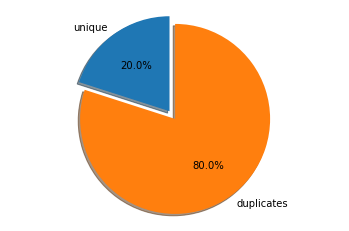

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

labels = 'unique', 'duplicates'
nb_duplicates = number_of_rows_all - number_of_rows_unique
sizes = [number_of_rows_unique, nb_duplicates]
explode = (0, 0.1)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

# Data analysis

### Lire la base de données "test" dans un dataframe

In [15]:
df_pcr = pd.read_sql('select * from test', con=con)
df_pcr['pcr'] = df_pcr['pcr'].replace(['P','N'],['Positive','Negative'])

### jointure "df_patient" avec "df_pcr"

In [16]:
#Séléction patient qui ont effectué un test pcr
df_patient_pcr = pd.merge(df_patient, df_pcr, left_on='patient_id', right_on='patient_id')


###  Propagation Covid-19 par age

/home/hirousto/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


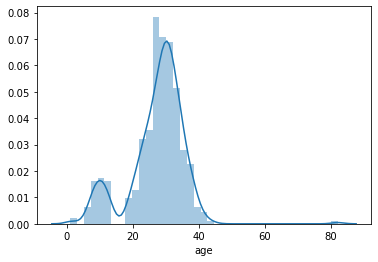

In [17]:
import seaborn as sns
df_pt_per_age = df_patient_pcr[['age','pcr']]
sns.distplot(df_pt_per_age[df_pt_per_age['pcr']=='Positive']['age'])


### Discussion

D'après les données fournies, la contamination est concentrée sur les personnes d'âge entre 20 et 40 ans; ce qui explique: "porteur sain du virus"

###  Propagation Covid-19 par état

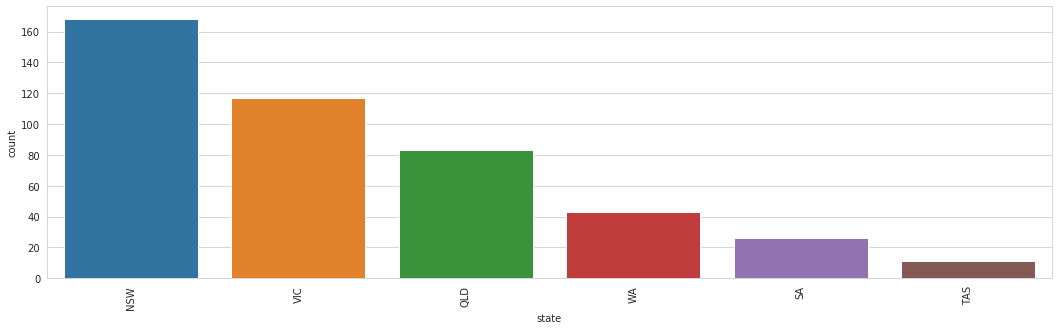

In [18]:
fig = plt.figure(figsize=(18,5))
sns.set_style('whitegrid')
df_pt_plt = df_patient_pcr[['state','pcr']]
sns.countplot(df_pt_plt[df_pt_plt['pcr']=='Positive']['state'],order=df_pt_plt[df_pt_plt['pcr']=='Positive']['state'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

###  Plot Map

###  Calcule ratio positive

In [19]:
df_pcr_count = df_pt_plt.groupby('state').size().reset_index(name='counts')
is_pos_pcr =  df_pt_plt['pcr']=='Positive'
df_pcr_pos = df_pt_plt[is_pos_pcr]
df_pcr_count_pos = df_pcr_pos.groupby('state').size().reset_index(name='counts_pos')

df_ratio = df_pcr_count.merge(df_pcr_count_pos, on='state')
df_ratio_final = df_ratio['counts_pos'].div(df_ratio['counts']).to_frame()
df_ratio_final.columns = ['ratio']
df_ratio_final.head()

ratio
0  0.255319
1  0.241279
2  0.228070
3  0.234043
4  0.268966

/home/hirousto/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


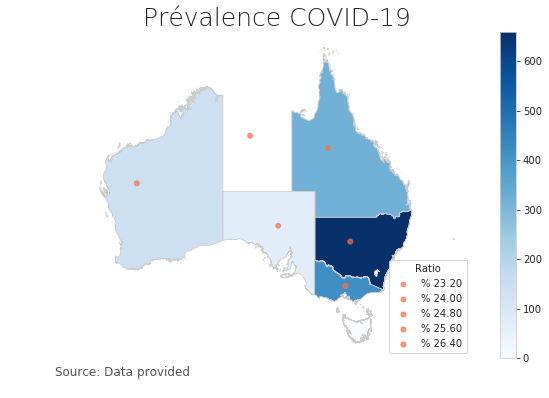

In [24]:
import geopandas as gpd
import numpy as np

#ouvrir fichier map de l'Australie
fp = "map/States Map.shp"
map_df = gpd.read_file(fp)


merged = map_df.set_index('ISO_SUB').join(df_pcr_count.set_index('state'))
merged.describe()
variable = 'counts'
np_counts = df_pcr_count['counts'].values
vmin, vmax = 0, np.amax(np_counts)
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
             
ax.set_title('Prévalence COVID-19', fontdict={'fontsize': '25', 'fontweight' : '3'})# create an annotation for the data source
ax.annotate('Source: Data provided',xy=(0.1, .08), xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
#coordonnées latitude longitude pour chaque état
csv_latlong = pd.read_csv("resources/states_latlong.csv")

lat=csv_latlong['LAT'].values
long=csv_latlong['LONG'].values
states_df = map_df.to_crs({'init': 'epsg:4326'})
x, y = long, lat 
scatter = ax.scatter(x, y, marker="o", alpha=0.7,color=scatter.cmap(0.7), zorder=5, s=df_ratio_final.ratio*100)
kw = dict(prop="sizes", num=6,color=scatter.cmap(0.7), fmt="% {x:.2f}")
legend2 = ax.legend(*scatter.legend_elements(**kw),
                   loc="lower right", title="Ratio")
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')


### Discussion

- Les états de l'est de pays ont effectué plus de tests que les autres états: les villes les plus peuplées se situent l'est de pays

- Le taux positivité (Cercle orange) reste presque identique dans les six états

## Références

[1] https://people.cs.pitt.edu/~kirk/cs1501/Pruhs/Spring2006/assignments/editdistance/Levenshtein%20Distance.htm